Link to dataset:
https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who?search=alcohol+effects

### Load Packages

In [126]:
# import packages
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time

## Load dataset and clean data - Adam

In [80]:
# import dataset
data = pd.read_csv('Life_Expectancy_Data.csv')

# clean column names
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# rename gdp column to make data more understandable
data = data.rename(columns={'gdp': 'gdp_per_capita'})

# rename HIV/AIDs column to make it usable
data = data.rename(columns={'hiv/aids': 'hiv_aids'})

# rename thinness 1-19 column to make it usable
data = data.rename(columns={'thinness__1-19_years': 'thinness_1_19_years'})

# rename thinness 5-9 column to make it usable
data = data.rename(columns={'thinness_5-9_years': 'thinness_5_9_years'})

# rename under five deaths column to make it usable
data = data.rename(columns={'under-five_deaths': 'under_five_deaths'})



/var/folders/0x/61vcmsg94cs94n1kc433lq8w0000gn/T/ipykernel_93192/955355231.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/0x/61vcmsg94cs94n1kc433lq8w0000gn/T/ipykernel_93192/955355231.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


In [81]:
# Drop columns with suspect data

# Dropping 'population' column
data.drop(columns=['population', 'bmi', 'infant_deaths', 'percentage_expenditure', 'hepatitis_b', 'alcohol', 'total_expenditure'],inplace=True)
    # population: data inconsistent and inaccurate
    # bmi: max bmi is over 80, which does not make sense -- lots of values like this
    # infant_deaths: mean value is 29-- true world highest value is 27
    # percentage_expenditure: seems very inaccurate, large number of values over 100%

In [82]:
# Additional Cleaning -- Dropping Missing Values

# drop missing gdp, life_expectancy, income_composition_of_resources values, 
data = data.dropna(subset=['gdp_per_capita','income_composition_of_resources'])


In [83]:
# Dropping rows with unreasonable gdp_per_capita values
    # the number 108 is chosen because an outside source confirmed that the lowest
    # gdp per capita during this time period is 108
data = data.loc[data.gdp_per_capita >= 108]

# Dropping rows with unreasonable under_five_deaths values
    # the number 180 is chosen because an outside source confirmed that the highest value should be 225 for this period
data = data.loc[data.under_five_deaths <= 225]

In [84]:
# reset the index numbers

data = data.reset_index(drop=True)

In [85]:
data.isnull().sum()

country                             0
year                                0
status                              0
life_expectancy                     2
adult_mortality                     2
measles                             0
under_five_deaths                   0
polio                              10
diphtheria                         10
hiv_aids                            0
gdp_per_capita                      0
thinness_1_19_years                24
thinness_5_9_years                 24
income_composition_of_resources     0
schooling                           0
dtype: int64

In [86]:
data = data.dropna()

In [87]:
data.isnull().sum()

country                            0
year                               0
status                             0
life_expectancy                    0
adult_mortality                    0
measles                            0
under_five_deaths                  0
polio                              0
diphtheria                         0
hiv_aids                           0
gdp_per_capita                     0
thinness_1_19_years                0
thinness_5_9_years                 0
income_composition_of_resources    0
schooling                          0
dtype: int64

In [88]:
# add in continents to be a categorical variable
continents_df = pd.read_csv('gdp_lifeExpectancy.csv')
continents = continents_df[['country', 'continent']]
continents.head(1)

country continent
0  Afghanistan      Asia

In [89]:
data = pd.merge(data, continents, on='country')

In [90]:
data.head(1)

country  year      status  life_expectancy  adult_mortality  measles  \
0  Afghanistan  2015  Developing             65.0            263.0     1154   

   under_five_deaths  polio  diphtheria  hiv_aids  gdp_per_capita  \
0                 83    6.0        65.0       0.1       584.25921   

   thinness_1_19_years  thinness_5_9_years  income_composition_of_resources  \
0                 17.2                17.3                            0.479   

   schooling continent  
0       10.1      Asia

In [91]:
# dividing data into 80% training, 20% test
np.random.seed(2)
train = data.sample(round(data.shape[0]*0.8)) # 80% training, 20% test
test = data.drop(train.index)

In [92]:
# test model
ols_object = smf.ols(formula = 'life_expectancy~schooling*income_composition_of_resources+polio*adult_mortality*hiv_aids+np.log(gdp_per_capita)+thinness_1_19_years', data=train)
model = ols_object.fit()

# returning numerical/statistical analysis
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     9761.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:12:57   Log-Likelihood:                -42659.
No. Observations:               15773   AIC:                         8.534e+04
Df Residuals:                   15760   BIC:                         8.544e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [54]:
#Computing RMSE on test data
pred_life = model.predict(test)
np.sqrt(((test.life_expectancy - pred_life)**2).mean())

3.7142921243744267

Text(0, 0.5, 'Residuals')

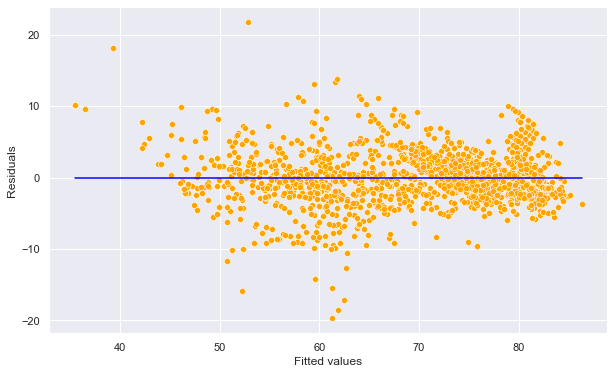

In [55]:
#Plotting residuals vs fitted values
sns.set(rc={'figure.figsize':(10,6)})
sns.scatterplot(x = (model.fittedvalues), y=(model.resid),color = 'orange')
sns.lineplot(x = [model.fittedvalues.min(),model.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

In [56]:
#Studentized residuals
out = model.outlier_test()
out

student_resid   unadj_p  bonf(p)
16519      -0.245935  0.805736      1.0
9653        1.007154  0.313876      1.0
19940      -0.597639  0.550089      1.0
17439       0.057875  0.953849      1.0
18471       0.305197  0.760220      1.0
...              ...       ...      ...
13847       0.998639  0.317985      1.0
6471        0.342860  0.731708      1.0
603        -2.536312  0.011212      1.0
11182      -0.385748  0.699689      1.0
2804       -2.133521  0.032897      1.0

[15784 rows x 3 columns]

In [57]:
#Number of points with absolute studentized residuals greater than 3
np.sum((np.abs(out.student_resid)>3))

159

In [58]:
#Computing the leverage statistic for each observation
influence = model.get_influence()
leverage = influence.hat_matrix_diag

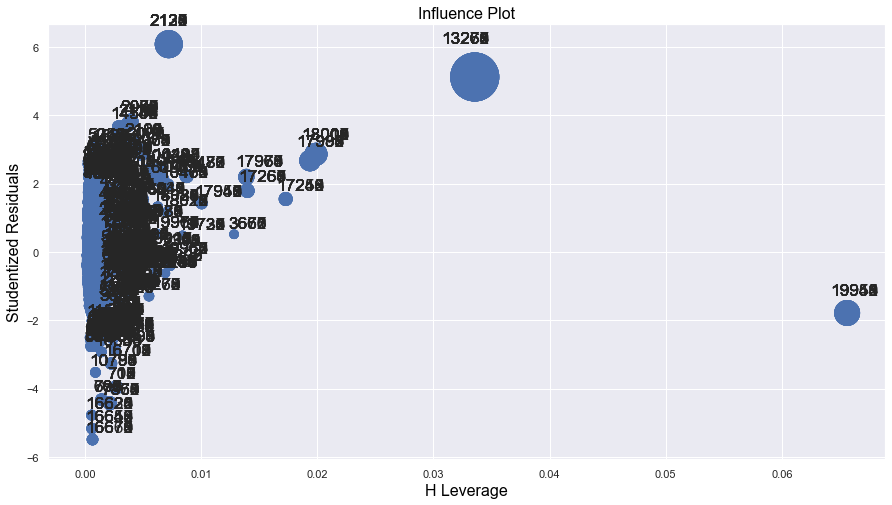

In [59]:
#Visualizng leverage against studentized residuals
sns.set(rc={'figure.figsize':(15,8)})
sm.graphics.influence_plot(model);

In [60]:
#Average leverage of points
average_leverage = (model.df_model+1)/model.nobs
average_leverage

0.0008236188545362392

In [61]:
# Determine the cutoff for high leverage - general convention is 4x the average leverage
cutoff = 4*((model.df_model+1)/model.nobs)

In [63]:
#Number of high leverage points in the dataset
np.sum(leverage>cutoff)

503

In [93]:
#Dropping influential points from data
train_filtered = train.drop(np.intersect1d(np.where(np.abs(out.student_resid)>3)[0],(np.where(leverage>cutoff)[0])))

KeyError: '[695, 1443, 2700, 2817, 3873, 4044, 4543, 5320, 5957, 6002, 6050, 7978, 10546, 12209] not found in axis'

In [65]:
data.iloc[1022:1026]

country  year     status  life_expectancy  adult_mortality  alcohol  \
1022  Australia  2006  Developed             81.2             66.0    10.31   
1023  Australia  2006  Developed             81.2             66.0    10.31   
1024  Australia  2006  Developed             81.2             66.0    10.31   
1025  Australia  2006  Developed             81.2             66.0    10.31   

      hepatitis_b  measles  under_five_deaths  polio  total_expenditure  \
1022         95.0        0                  2   92.0               8.49   
1023         95.0        0                  2   92.0               8.49   
1024         95.0        0                  2   92.0               8.49   
1025         95.0        0                  2   92.0               8.49   

      diphtheria  hiv_aids  gdp_per_capita  thinness_1_19_years  \
1022        92.0       0.1     36118.28381                  0.7   
1023        92.0       0.1     36118.28381                  0.7   
1024        92.0       0.1     36118.28381                  0.7   
1025        92.0       0.1     36118.28381                  0.7   

      thinness_5_9_years  income_composition_of_resources  schooling continent  
1022                 0.6                            0.915       20.3   Oceania  
1023                 0.6                            0.915       20.3   Oceania  
1024                 0.6                            0.915       20.3   Oceania  
1025                 0.6                            0.915       20.3   Oceania

## Variable Selection/VIF - Judd

In [94]:
data.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'measles', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids',
       'gdp_per_capita', 'thinness_1_19_years', 'thinness_5_9_years',
       'income_composition_of_resources', 'schooling', 'continent'],
      dtype='object')

In [95]:
data.isnull().sum()

country                            0
year                               0
status                             0
life_expectancy                    0
adult_mortality                    0
measles                            0
under_five_deaths                  0
polio                              0
diphtheria                         0
hiv_aids                           0
gdp_per_capita                     0
thinness_1_19_years                0
thinness_5_9_years                 0
income_composition_of_resources    0
schooling                          0
continent                          0
dtype: int64

In [99]:
#Predictors VIF will be caluclated for:

X = train[['adult_mortality','measles', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 
           'gdp_per_capita', 'thinness_1_19_years', 'thinness_5_9_years',
           'income_composition_of_resources', 'schooling']]

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# add constant column
X = add_constant(X)
# create empty dataframe to input VIF values
vif_data=pd.DataFrame()
# create row for each predictor in X
vif_data['predictor'] = X.columns

# for loop to fill in VIF values 
for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values,i)
    
print(vif_data)

                         predictor        VIF
0                            const  46.012654
1                  adult_mortality   1.951469
2                          measles   1.194178
3                under_five_deaths   1.591654
4                            polio   2.167635
5                       diphtheria   2.176732
6                         hiv_aids   1.555849
7                   gdp_per_capita   1.423011
8              thinness_1_19_years   1.547305
9  income_composition_of_resources   2.429417


In [103]:
data.corrwith(data.life_expectancy)

year                               0.154529
life_expectancy                    1.000000
adult_mortality                   -0.711417
measles                           -0.173098
under_five_deaths                 -0.517525
polio                              0.470361
diphtheria                         0.487223
hiv_aids                          -0.588924
gdp_per_capita                     0.486544
thinness_1_19_years               -0.580836
thinness_5_9_years                -0.581806
income_composition_of_resources    0.830276
schooling                          0.806966
dtype: float64

**It appears `thinness_1_19_years`, `thinness_5_9_years`, `income_composition_of_resources`, and `schooling` exhibit multicollinearity. Therefore, we will remove `thinness_5_9_years` and `schooling` since they are less correlated with `life_expectancy`.**

In [104]:
# run test model without interactions and 
ols_object = smf.ols(formula = 'life_expectancy~adult_mortality+measles+under_five_deaths+polio+diphtheria+hiv_aids+gdp_per_capita+thinness_1_19_years+income_composition_of_resources', data=train)
model = ols_object.fit()

# returning numerical/statistical analysis
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 1.087e+04
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:26:08   Log-Likelihood:                -43897.
No. Observations:               15773   AIC:                         8.781e+04
Df Residuals:                   15763   BIC:                         8.789e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [142]:
#Creating a dataframe with all the predictors
X = train[['adult_mortality', 'measles', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 'gdp_per_capita', 'thinness_1_19_years', 'income_composition_of_resources']]
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = train[['adult_mortality', 'measles', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 'gdp_per_capita', 'thinness_1_19_years', 'income_composition_of_resources']]

In [146]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('life_expectancy~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [147]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [148]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [149]:
models_best = forward_selection()

Processed  9 models on 1 predictors in 0.1439380645751953 seconds.
Processed  8 models on 2 predictors in 0.0765388011932373 seconds.
Processed  7 models on 3 predictors in 0.07207417488098145 seconds.
Processed  6 models on 4 predictors in 0.0925130844116211 seconds.
Processed  5 models on 5 predictors in 0.09268903732299805 seconds.
Processed  4 models on 6 predictors in 0.09149694442749023 seconds.
Processed  3 models on 7 predictors in 0.06944394111633301 seconds.
Processed  2 models on 8 predictors in 0.041433095932006836 seconds.
Processed  1 models on 9 predictors in 0.02368903160095215 seconds.
Total elapsed time: 0.7462823390960693 seconds.


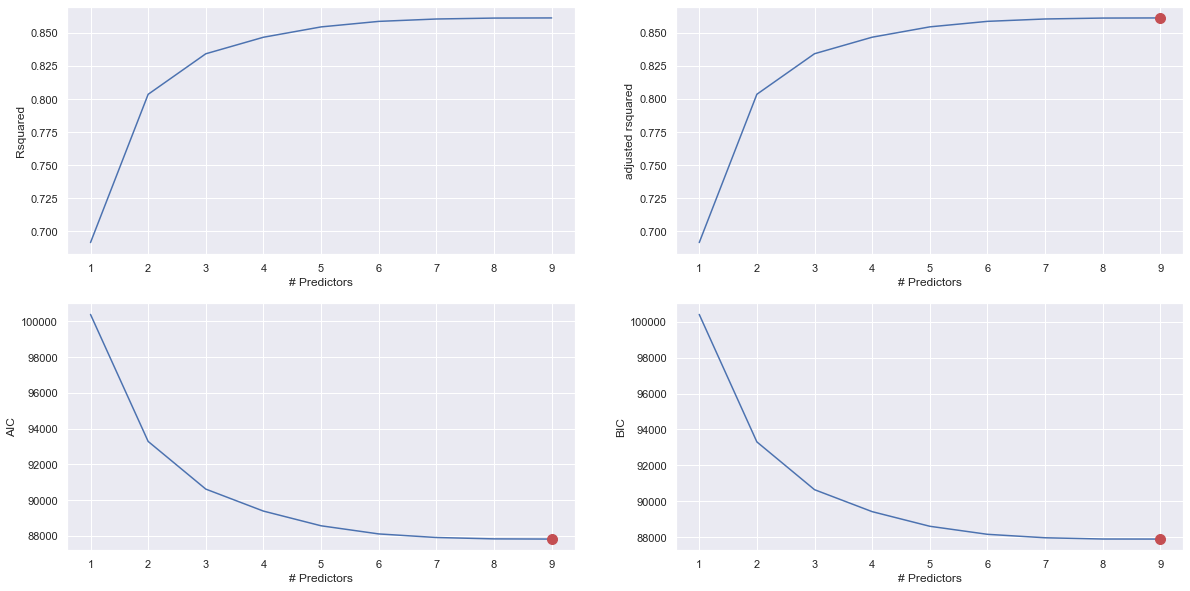

In [150]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [152]:
best_fwd_reg_model = models_best['model'][9]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 1.087e+04
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:41:39   Log-Likelihood:                -43897.
No. Observations:               15773   AIC:                         8.781e+04
Df Residuals:                   15763   BIC:                         8.789e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          53.6787      0.211    253.953      0.000      53.264      54.093
income_composition_of_resources    25.2267      0.247    102.194      0.000      24.743      25.711
hiv_aids                           -0.4300      0.006    -67.620      0.000      -0.442      -0.418
adult_mortality                    -0.0157      0.000    -48.810      0.000      -0.016      -0.015
under_five_deaths                  -0.0289      0.001    -28.618      0.000      -0.031      -0.027
diphtheria                          0.0353      0.002     18.193      0.000       0.031       0.039
thinness_1_19_years                -0.1925      0.010    -20.050      0.000      -0.211      -0.174
gdp_per_capita                   3.578e-05   2.51e-06     14.231      0.000    3.09e-05    4.07e-05
polio                               0.0170      0.002      8.884      0.000       0.013       0.021
measles                          1.852e-05   5.21e-06      3.556      0.000    8.31e-06    2.87e-05
==============================================================================
Omnibus:                     2110.412   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14258.292
Skew:                           0.455   Prob(JB):                         0.00
Kurtosis:                       7.568   Cond. No.                     1.63e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Final Regression Analysis - Alissa